In [82]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [77]:
path='/Users/leizhao/bootcamp_lei_zhao/'

df=pd.read_csv("/Users/leizhao/bootcamp_lei_zhao/project/data/AAPL.csv")

numeric_cols = df.select_dtypes("number").columns
numeric_summary = df[numeric_cols].describe()
numeric_cols
numeric_summary 
df["Date"] = pd.to_datetime(df["Date"])
df["Return"] = df["Adj Close"].pct_change().round(4)
df["Roll_Volume"] = df["Volume"].rolling(window=5).sum()
df["Roll_Volume"]=np.log(df["Roll_Volume"])
df = df[["Date", "Roll_Volume", "Return"]]
df

,Date,Roll_Volume,Return
0,1980-12-12,NaN,NaN
1,1980-12-15,NaN,-0.0522
2,1980-12-16,NaN,-0.0734
3,1980-12-17,NaN,0.0248
4,1980-12-18,20.629546,0.0290
...,...,...,...
10404,2022-03-18,20.036028,0.0209
10405,2022-03-21,20.010003,0.0085
10406,2022-03-22,19.986397,0.0208
10407,2022-03-23,19.977504,0.0082


In [72]:
## missing value
df.isna().sum()


Date           0
Roll_Volume    4
Return         1
dtype: int64

df_clean=df.dropna()
df_clean

In [66]:
df_clean.to_csv('/Users/leizhao/bootcamp_lei_zhao/project/data/processed.csv',index=False)

In [79]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

df_clean['outlier_iqr'] = detect_outliers_iqr(df['Roll_Volume'])
df_clean['outlier_z'] = detect_outliers_zscore(df['Return'])

df_clean

/var/folders/p1/5k3lxhdx3qqf1lphkh6b4_fw0000gn/T/ipykernel_53378/3746189768.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['outlier_iqr'] = detect_outliers_iqr(df['Roll_Volume'])
/var/folders/p1/5k3lxhdx3qqf1lphkh6b4_fw0000gn/T/ipykernel_53378/3746189768.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['outlier_z'] = detect_outliers_zscore(df['Return'])


,Date,Roll_Volume,Return,outlier_iqr,outlier_z
4,1980-12-18,20.629546,0.0290,False,False
5,1980-12-19,20.010190,0.0610,False,False
6,1980-12-22,19.678041,0.0487,False,False
7,1980-12-23,19.495121,0.0422,False,False
8,1980-12-24,19.354406,0.0526,False,False
...,...,...,...,...,...
10404,2022-03-18,20.036028,0.0209,False,False
10405,2022-03-21,20.010003,0.0085,False,False
10406,2022-03-22,19.986397,0.0208,False,False
10407,2022-03-23,19.977504,0.0082,False,False


In [87]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

target_col = 'Return' if 'Return' in df_clean.columns else df_clean.select_dtypes(include=['number']).columns[1]
df_clean['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df_clean['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df_clean[['outlier_iqr', 'outlier_z']].mean()

/var/folders/p1/5k3lxhdx3qqf1lphkh6b4_fw0000gn/T/ipykernel_53378/2988479043.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['outlier_iqr'] = detect_outliers_iqr(df[target_col])
/var/folders/p1/5k3lxhdx3qqf1lphkh6b4_fw0000gn/T/ipykernel_53378/2988479043.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)


outlier_iqr    0.053628
outlier_z      0.012686
dtype: float64

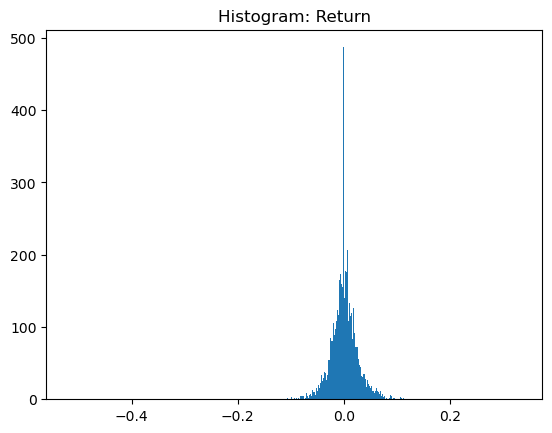

In [88]:
plt.figure()
plt.hist(df[target_col], bins=1000)
plt.title(f'Histogram: {target_col}')
plt.show()

In [93]:
## description 
from scipy.stats import skew, kurtosis
import seaborn as sns
desc = df_clean[["Roll_Volume", "Return"]].describe().T
desc['skew'] = [skew(df_clean[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df_clean[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Roll_Volume,10405.0,20.901845,0.823961,16.958006,20.356734,20.848622,21.466786,23.385632,-0.136669,0.373305
Return,10405.0,0.001136,0.028354,-0.518700,-0.013000,0.000000,0.014700,0.332300,-0.379406,18.165730


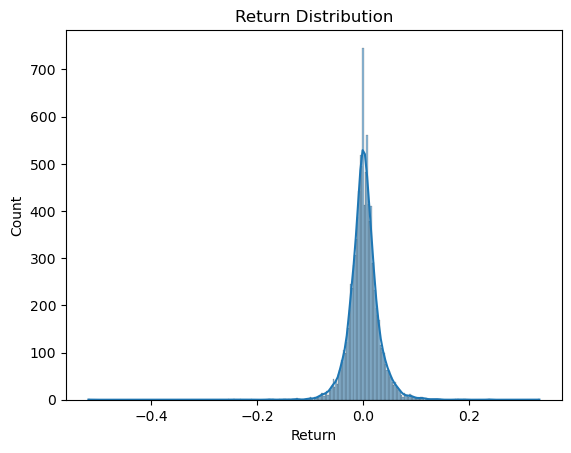

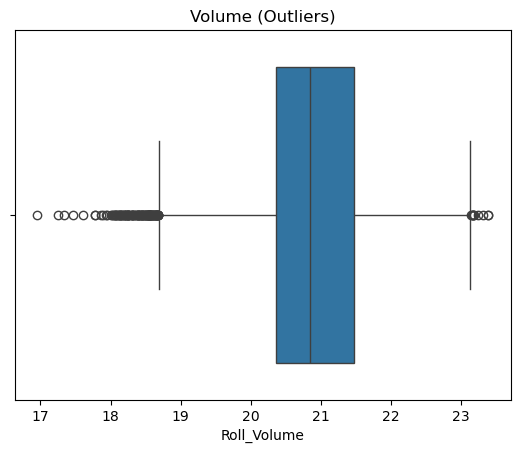

In [94]:
sns.histplot(df_clean['Return'], kde=True)
plt.title('Return Distribution')
plt.show()

sns.boxplot(x=df_clean["Roll_Volume"])
plt.title('Volume (Outliers)')
plt.show()


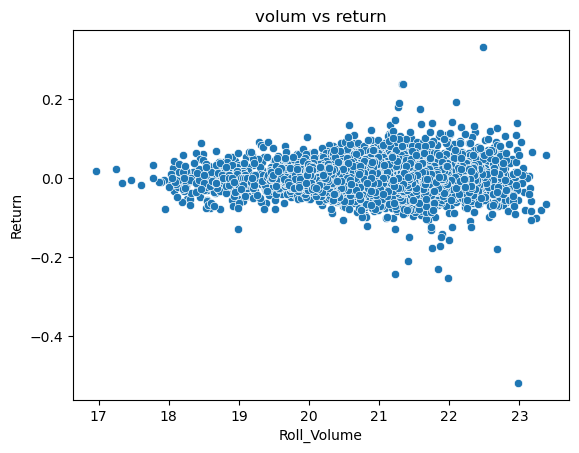

4        0.0610
5        0.0487
6        0.0422
7        0.0526
8        0.0923
          ...  
10404    0.0085
10405    0.0208
10406    0.0082
10407    0.0227
10408       NaN
Name: Return, Length: 10405, dtype: float64

In [102]:
sns.scatterplot(data=df_clean, x='Roll_Volume', y='Return')
plt.title('volum vs return')
plt.show()


In [104]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit

X = df_clean[['Roll_Volume']]
y = df_clean['Return'].shift(-1)

df_model = pd.concat([X, y], axis=1).dropna()
X = df_model[['Roll_Volume']]
y = df_model['Return']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'One-step-ahead   R²={r2:.4f}  RMSE={rmse:.6f}')

One-step-ahead   R²=-0.0011  RMSE=0.017808


In [105]:
df = df_clean.copy()
df['lag_1'] = df['Return'].shift(1)
df['roll_mean_5'] = df['Return'].rolling(5).mean().shift(1)
df['momentum_10'] = df['Return'].rolling(10).sum().shift(1)
df['zscore_20'] = (df['Return'] - df['Return'].rolling(20).mean()) / df['Return'].rolling(20).std()
df['zscore_20'] = df['zscore_20'].shift(1)

df['roll_vol_20'] = df['Return'].rolling(20).std().shift(1)

df['y_next_ret'] = df['Return'].shift(-1)

df['y_up'] = (df['y_next_ret'] > 0).astype(int)

df_feat = df.dropna().copy()

df_feat.head()


,Date,Roll_Volume,Return,outlier_iqr,outlier_z,lag_1,roll_mean_5,momentum_10,zscore_20,roll_vol_20,y_next_ret,y_up
24,1981-01-19,18.482506,0.0605,True,False,-0.0080,-0.00538,-0.1022,-0.454025,0.039194,-0.0304,0
25,1981-01-20,18.546531,-0.0304,False,False,0.0605,0.00828,-0.0200,1.209697,0.040613,0.0196,1
26,1981-01-21,18.560651,0.0196,False,False,-0.0304,0.00932,-0.0059,-0.933020,0.039871,0.0115,1
27,1981-01-22,18.731876,0.0115,False,False,0.0196,0.01242,0.0563,0.367615,0.038777,-0.0038,0
28,1981-01-23,18.715831,-0.0038,False,False,0.0115,0.01064,0.0880,0.203237,0.037838,-0.0153,0


              precision    recall  f1-score   support

           0       0.47      0.88      0.61       977
           1       0.50      0.10      0.17      1100

    accuracy                           0.47      2077
   macro avg       0.48      0.49      0.39      2077
weighted avg       0.48      0.47      0.38      2077



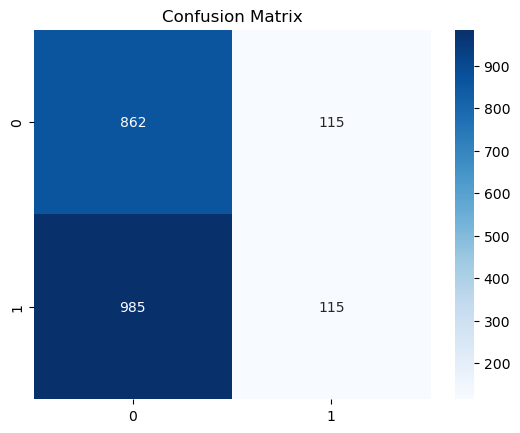

In [108]:
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

features = ['lag_1', 'roll_mean_5']

X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']   
y_tr_clf, y_te_clf = train['y_up'], test['y_up']           

clf = Pipeline([
    ('scaler', StandardScaler()),  
    ('logit', LogisticRegression(max_iter=1000))
])
clf.fit(X_tr, y_tr_clf)

predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))

cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [111]:

X_base = df_feat['lag_1'].values.reshape(-1,1)  
y = df_feat['y_next_ret'].values                

from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_base, y)
y_hat = model.predict(X_base)

resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)

x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)

gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def fit_fn(X, y):
    m = LinearRegression().fit(X, y)
    return m

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

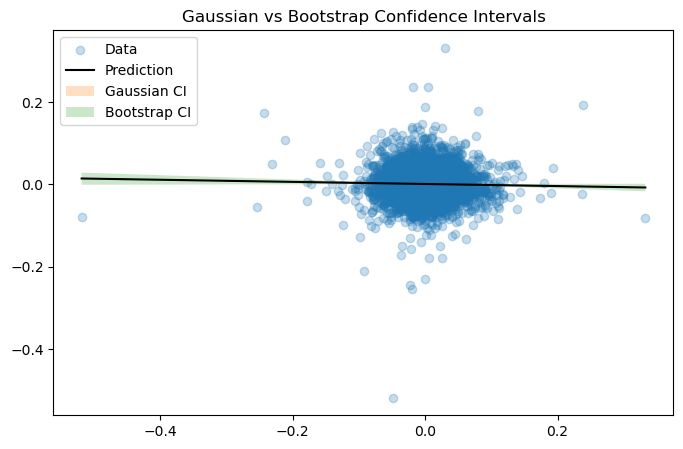

In [115]:
plt.figure(figsize=(8,5))
plt.scatter(X_base, y, alpha=0.25, label='Data')
plt.plot(x_grid, pred_line, label='Prediction', color='black')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend()
plt.title('Gaussian vs Bootstrap Confidence Intervals')

plt.savefig("example_plot.png", dpi=300, bbox_inches='tight')  
plt.show() 